# Import Libraries

In [205]:
from pathlib import Path
import glob
import pickle

import pandas as pd
import numpy as np
import math

import cv2
from sklearn.decomposition import PCA, FastICA, NMF
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import Imputer, StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_regression
#from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor
from gmdhpy.gmdh import MultilayerGMDH #!pip install GmdhPy==0.1.1a0 

#from keras import models
#from keras import layers
#from keras import optimizers
#from keras.callbacks import EarlyStopping

import pylab as plt
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

# Getting the Data & Data Cleaning

In [206]:
!dir -lhS gt   #!ls -lhS gt

 Volume in drive D is DATA
 Volume Serial Number is 9E8A-424E

 Directory of D:\pig_weight_estimation


 Directory of D:\pig_weight_estimation\gt

02/13/2019  01:33 AM    <DIR>          .
02/13/2019  01:33 AM    <DIR>          ..
07/09/2018  03:53 PM             1,653 2018-05-31 14.24.37_gt.png
07/09/2018  03:53 PM             1,946 2018-05-31 14.24.53_gt.png
07/09/2018  03:53 PM             2,101 2018-05-31 14.24.55_gt.png
07/09/2018  03:53 PM             1,633 2018-05-31 14.25.10_gt.png
07/09/2018  03:53 PM             1,654 2018-05-31 14.25.12_gt.png
07/09/2018  03:18 PM             1,765 2018-05-31 14.30.17_gt.png
07/09/2018  03:53 PM             1,715 2018-05-31 14.30.18_gt.png
07/09/2018  03:54 PM             1,915 2018-05-31 14.30.20_gt.png
07/09/2018  03:54 PM             1,734 2018-05-31 14.36.11_gt.png
07/09/2018  03:54 PM             1,479 2018-05-31 14.36.19_gt.png
07/09/2018  03:54 PM             1,697 2018-05-31 14.36.21_gt.png
07/09/2018  03:54 PM             1,554 2018-

07/09/2018  04:04 PM             1,978 2018-06-18 13.10.18_gt.png
07/09/2018  04:04 PM             1,717 2018-06-18 13.10.23_gt.png
07/09/2018  04:04 PM             1,978 2018-06-18 13.10.24_gt.png
07/09/2018  03:35 PM             1,665 2018-06-18 13.10.26_gt.png
07/09/2018  04:04 PM             1,816 2018-06-18 13.17.25_gt.png
07/09/2018  04:04 PM             1,758 2018-06-18 13.17.26_gt.png
07/09/2018  04:04 PM             1,717 2018-06-18 13.17.27_gt.png
07/09/2018  04:04 PM             1,778 2018-06-18 13.17.28_gt.png
07/09/2018  04:04 PM             1,720 2018-06-18 13.17.29_gt.png
07/09/2018  04:04 PM             1,800 2018-06-18 13.17.30_gt.png
07/09/2018  04:04 PM             1,822 2018-06-18 13.17.33_gt.png
07/09/2018  03:35 PM             1,842 2018-06-18 13.28.48_gt.png
07/09/2018  04:04 PM             2,014 2018-06-18 13.28.49_gt.png
07/09/2018  04:04 PM             1,771 2018-06-18 13.29.05_gt.png
07/09/2018  04:04 PM             1,914 2018-06-18 13.29.06_gt.png
07/09/2018

File Not Found
File Not Found


In [207]:
df = pd.read_csv('gt/weights_31-05_20-06.csv')

In [208]:
# show first 10 rows
df.head(10)

,Image,Weight,comments
0,2018-05-31 14.19.14,-1.0,0.0
1,2018-05-31 14.24.37,58.8,NaN
2,2018-05-31 14.24.53,58.8,NaN
3,2018-05-31 14.24.55,58.8,NaN
4,2018-05-31 14.25.10,58.8,NaN
5,2018-05-31 14.25.12,58.8,NaN
6,2018-05-31 14.30.17,42.9,NaN
7,2018-05-31 14.30.18,42.9,NaN
8,2018-05-31 14.30.20,42.9,NaN
9,2018-05-31 14.36.11,58.9,NaN


In [209]:
# show rows with incorrect values of Weight
minimum = 10
df[ df['Weight'].isnull() | (df['Weight'] < minimum) ]

,Image,Weight,comments
0,2018-05-31 14.19.14,-1.0,0.0
37,2018-05-31 15.10.43,-1.0,NaN
38,2018-05-31 15.10.44,-1.0,NaN
59,2018-05-31 15.26.05,-1.0,NaN
60,2018-05-31 15.26.13,-1.0,NaN
61,2018-06-01 09.28.42,-1.0,0.0
94,2018-06-01 09.58.30,-1.0,NaN
95,2018-06-01 09.58.35,-1.0,NaN
96,2018-06-01 09.58.44,-1.0,NaN
97,2018-06-01 09.58.45,-1.0,NaN


In [210]:
# show rows with valuable comments
df[ df['comments'].notnull() & (df['comments'] > minimum) ]

,Image,Weight,comments
201,2018-06-01 11.46.54,-1.0,71.7
202,2018-06-01 11.47.35,-1.0,71.7
203,2018-06-01 11.47.39,-1.0,71.7


In [211]:
def clean_dataframe(dframe):
    """Cleaning dataset from incorrect data
    Parameters
    ----------
    dframe : [float, string], Pandas.Dataframe.
    Returns
    -------
    df :  [float, string], Pandas.Dataframe
    """
    df = dframe.copy()
    missing = df.Weight ==-1
    column_name = 'Weight'
    # fill incorrect values of weight by valuable comments
    df.loc[missing, column_name] = df[df['comments'].notnull()].comments
    # select rows with correct values of weight
    df = df[(df['Weight'].notnull()) & (df['Weight'] > minimum)]
    return df

def second_version_of_name(name):
    img_name = name[:4] + "-" + name[4:6] + "-" + name[6:8] + " " + name[9:11] + "." + name[11:13] + "." + name[13:15]
    return img_name

def load_data(path_to_dir, csv_name):
    """Loading and matching images and weights by name in dataset
    Parameters
    ----------
    path_to_dir : string, directory with pig images.
    csv_name : string, file with weights dataset.
    Returns
    -------
    img_set : list, list with pigs image
    weights : list, list with pigs weight
    """      
    df = pd.read_csv(path_to_dir+'/'+csv_name)
    df = clean_dataframe(df)
    img_set, weights = [], []
    img_names = df.Image.values
    weights_old = df.Weight.values
    for f in range(0, len(img_names)):
        name = img_names[f]
        path1 = path_to_dir + '/' + str(name) + '_gt.png'
        file1 = Path( path1 )
        
        path2 = path_to_dir + '/' + second_version_of_name(str(name)) + '_gt.png'
        file2 = Path( path2 )
                     
        if file1.is_file():
            img_set.append(cv2.imread(path1))
            weights.append(weights_old[f])
        elif file2.is_file():
            #print(file2)
            img_set.append(cv2.imread(path2))
            weights.append(weights_old[f])
    return img_set, weights

In [212]:
path_to_dir = './gt'
csv_name = 'weights_31-05_20-06.csv'
img_set, weights = load_data(path_to_dir, csv_name)

#len(img_set), img_set[0].shape

# Feature extraction & Dataset creation

In [213]:
def extract_features(img):
    """Extracting features from image
    Parameters
    ----------
    img : list, image as array of digits.
    Returns
    -------
    list, extracted features
    """            
    lower_color = np.array([0,255,255])
    upper_color = np.array([0,255,255]) 
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower_color, upper_color)
  
    ret, thresh = cv2.threshold(mask, 40, 255, 0)
    im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour = contours[0]
 
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    area_perimeter = [area, perimeter]
  
    (ex, ey), (MA, ma), angle = cv2.fitEllipse(contour)
    ellipse = [ex, ey, MA, ma, angle]
    
    rectangle = list(cv2.boundingRect(contour))
    
    M = cv2.moments(contour)
    moments = [v for k, v in M.items()]
    
    return area_perimeter + ellipse + rectangle + moments


#test extractor
#features = extract_features(img_set[0])
#features

In [214]:
def create_dataset(img_list, weight_list):
    """Creating dataset with features and target
    Parameters
    ----------
    img_list : list, images of pigs.
    weight_list : list, weigths of pigs.
    Returns
    -------
    dataset : Pandas.Dataframe
    """       
    features_num = len(extract_features( img_list[0] ))
    features_names = ['f'+str(i) for i in range(features_num)]
    dataset = pd.DataFrame( columns = features_names + ['weight'] ) 
    for i in range(0, len(img_list)):
        features = extract_features( img_list[i] )
        row = {features_names[j] : features[j] for j in range(0, len(features))}
        row.update({'weight': weight_list[i]})
        dataset = dataset.append( row, ignore_index=True )   
    return dataset

In [215]:
dataset = create_dataset(img_set, weights)
#dataset.shape

In [216]:
dataset.to_csv('dataset.csv')

# Data exploration

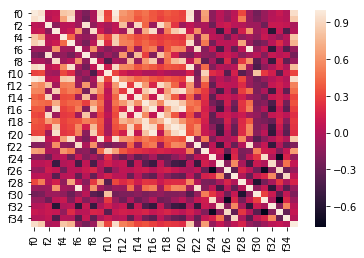

In [217]:
# visualize linear dependence between variables
corr = dataset.corr()
sns.heatmap(corr)

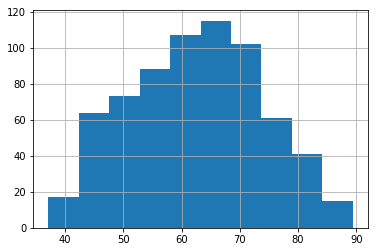

In [218]:
#visualize distribution
dataset.weight.hist()

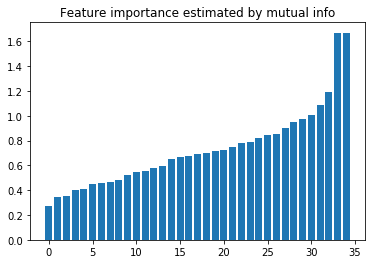

In [219]:
# visualize linear&non-linear dependence between variables and weight
X, y = dataset.iloc[:,:-1], dataset.iloc[:,-1]
feature_importance = mutual_info_regression(X, y)
indexes = np.argsort(feature_importance)

pyplot.bar(np.arange(len(feature_importance)), feature_importance[indexes])
pyplot.title('Feature importance estimated by mutual info')
pyplot.show()

# Splitting Data

In [220]:
#X = X.iloc[:,indexes[18:]]
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Building model

In [225]:
model = MultilayerGMDH(ref_functions=('linear_cov'),
                      criterion_type='test_bias',
                      criterion_minimum_width=5,
                      admix_features=True,
                      max_layer_count=20,
                      normalize=True,
                      stop_train_epsilon_condition=0.0001,
                      layer_err_criterion='top',
                      alpha=0.5,
                      n_jobs=1)

model.fit(X_train, y_train)

# save the model to disk
pickle.dump(model, open('model.pkl', 'wb'))

C:\Users\syste\Anaconda3\lib\site-packages\gmdhpy\data_preprocessing.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data_x = data_x.as_matrix()
C:\Users\syste\Anaconda3\lib\site-packages\gmdhpy\data_preprocessing.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data_y = data_y.as_matrix()


train layer0 in 2.14 sec
train layer1 in 8.47 sec
train layer2 in 8.41 sec
train layer3 in 8.45 sec
train layer4 in 8.44 sec
train layer5 in 8.53 sec
train layer6 in 8.49 sec
train layer7 in 8.57 sec
train layer8 in 8.44 sec
train layer9 in 8.40 sec
train layer10 in 8.37 sec
train layer11 in 8.38 sec
train layer12 in 8.42 sec


In [226]:
# load the model from disk
# model = pickle.load(open('model.pkl', 'rb'))

# make data for evaluation
real = y_test.values
pred = model.predict(X_test)
indexes = np.argsort(pred)
real=real[indexes]
pred=pred[indexes]

mse = mean_squared_error(real, pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(real, pred)

rmse, mse, mae

C:\Users\syste\Anaconda3\lib\site-packages\gmdhpy\data_preprocessing.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data_x = data_x.as_matrix()


(3.985231504693849, 15.8820701460044, 2.692481007168963)

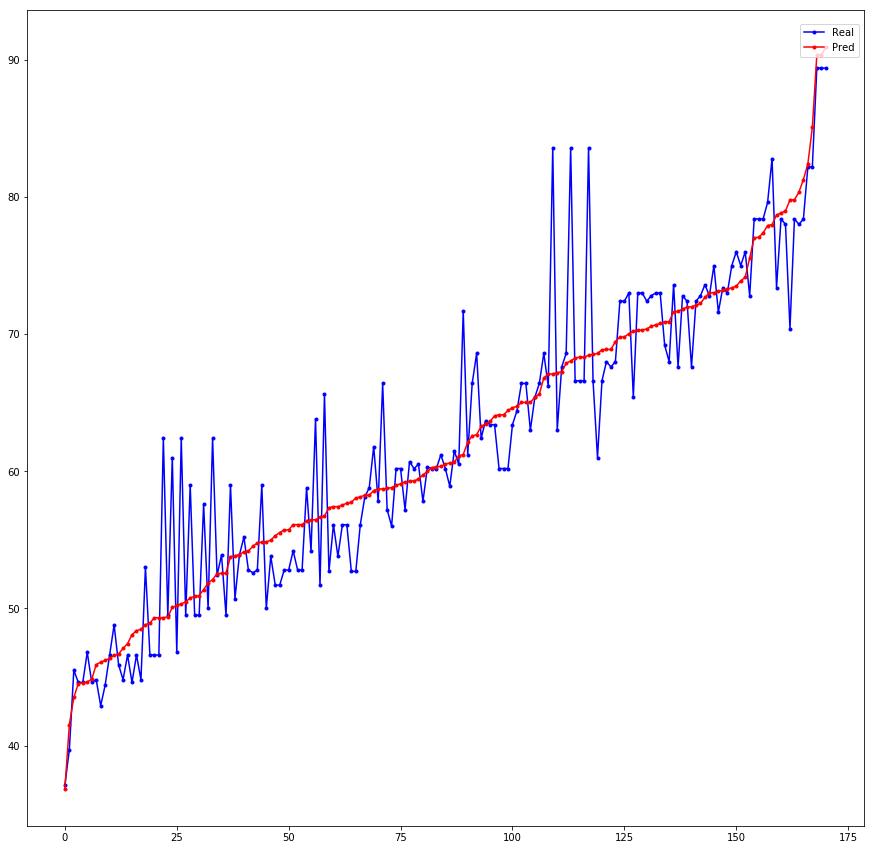

In [228]:
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 10, 'figure.figsize':[15,15]})
plt.plot(real,'b.-', pred, 'r.-')
figure = plt.gcf()
figure.legend(['Real','Pred'], loc=5, bbox_to_anchor=(0.8, 0.75))
plt.show()

In [229]:
real = y.values
pred = model.predict(X)
indexes = np.argsort(pred)
real=real[indexes]
pred=pred[indexes]

mse = mean_squared_error(real, pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(real, pred)

rmse, mse, mae

C:\Users\syste\Anaconda3\lib\site-packages\gmdhpy\data_preprocessing.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data_x = data_x.as_matrix()


(3.5725141692474445, 12.762857489473758, 2.375617596811824)

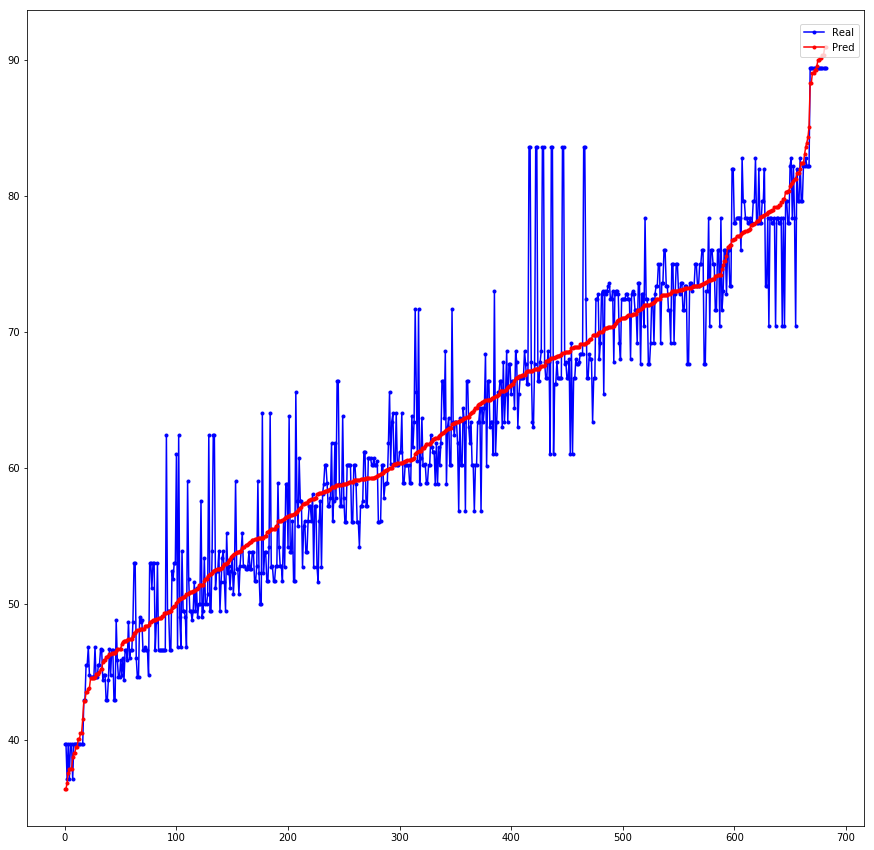

In [230]:
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 10, 'figure.figsize':[15,15]})
plt.plot(real,'b.-', pred, 'r.-')
figure = plt.gcf()
figure.legend(['Real','Pred'], loc=5, bbox_to_anchor=(0.8, 0.75))
plt.show()